

>Here's an overview of what seems to be missing or incomplete in relation to Assignments 1 through 4:

1. **Empirical Analysis 2**:
   - **Choice Justification**: The notebook lacks explicit justification for the choice of the financial series, the observation period, and the frequency. This is required as per the assignment instructions.
   - **Deterministic Trend Analysis**: While the notebook includes unit root tests (ADF tests), it does not explicitly address the presence of deterministic trends (constant or constant and time trend) in the first differences of the series.
   - **Seasonal Variations**: There is no clear analysis of seasonal variations in the series.
   - **Stationary ARMA Model**: The notebook does not appear to estimate a stationary ARMA model for the cyclical component of each series.

2. **Empirical Analysis 3**:
   - **Cointegration Rank Test and Estimation**: While the notebook includes cointegration testing, there is no clear documentation or commentary on the sign of the estimated coefficients in the long-term equations.
   - **Causality Tests and Error-Correcting Mechanisms**: The notebook does not explicitly perform causality tests or validate error-correcting mechanisms, which are important components of the VECM analysis.

3. **Empirical Application 4**:
   - **Impulse Response Analysis**: The notebook includes some impulse response analysis. However, it does not clearly compare the results from the VAR model with first differences (if no cointegration) and the VAR model in levels (in case of cointegration), as required by the assignment.

4. **General Observations**:
   - **Graphs and Visuals**: While the notebook includes several plots, it may lack specific graphs that illustrate key developments in line with the assignment requirements.
   - **Comprehensive Analysis and Interpretation**: Each assignment requires a thorough analysis and interpretation of results, which seems to be only partially covered in the notebook.





In [102]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.api import VAR
from pandas_datareader import data as pdr
import datetime
from fredapi import Fred
import numpy as np

In [49]:
#pip install fredapi

In [112]:
api_key = '230970faf44ea208229d77dff9f995f3'
fred = Fred(api_key=api_key)

# Define the series IDs
series_ids = {


    'NASDAQ': 'NASDAQCOM',
    '10YR_Treasury_Yield': 'GS10',
    'Real_GDP': 'GDPC1',
    'ALLUKSHARES': 'SPASTT01GBM661N',
    'USD/GBP': 'DEXUSUK',
    'CPI': 'GBRCPIALLMINMEI',
    'UKGDP': 'UKNGDP'
}

# Define the observation period
start_date = '2000-01-01'
end_date = '2023-10-31'

# Download the data
data = {}
for series_name, series_id in series_ids.items():
    data[series_name] = fred.get_series(series_id, start_date, end_date, frequency='q')

# Transform the series (log)
for series_name, series_data in data.items():
    data[series_name] = pd.Series(data[series_name])

# Create a DataFrame from the log-transformed data
df = pd.DataFrame(data)
df=np.log(df.dropna())

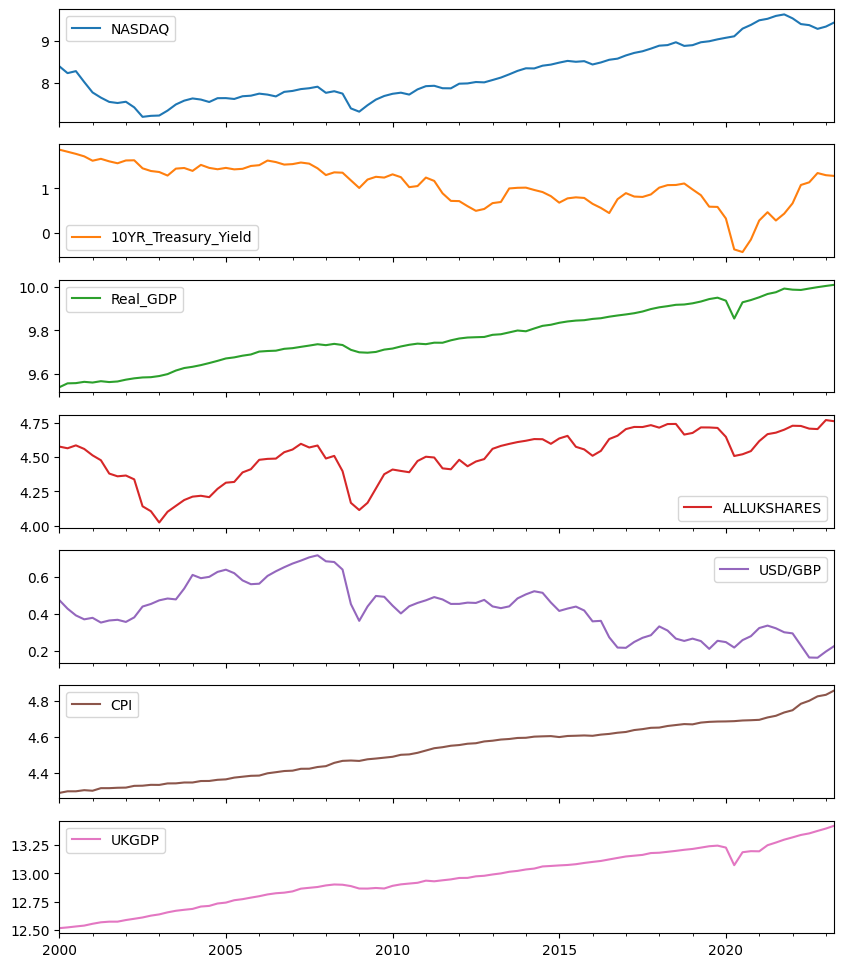

In [113]:
df.plot(subplots=True, figsize=(10, 12))
plt.show()

In [114]:
def determine_differencing_order_for_all(data):
    stat={}
    for column in data.columns:
        series = data[column].dropna()
        d = 0

        while True:
            # Perform Augmented Dickey-Fuller test for stationarity
            result = adfuller(series)

            print(f"Results for column '{column}' (I({d})):")
            print(f"ADF Statistic: {result[0]}")
            print(f"P-Value: {result[1]}")
            print("Critical Values:")
            for key, value in result[4].items():
                print(f"  {key}: {value}")

            if result[1] <= 0.05:
                print(f"Series '{column}' is stationary at order I({d}) (reject null hypothesis)")
                break
            else:
                print(f"Series '{column}' is non-stationary at order I({d}) (fail to reject null hypothesis)")
                d += 1
                series = series.diff().dropna()  # Differencing the series
            print('\n')
        stat[column]=d

    return(stat)

In [115]:
orders =determine_differencing_order_for_all(df)
orders

Results for column 'NASDAQ' (I(0)):
ADF Statistic: -0.015777168663409138
P-Value: 0.957207713854982
Critical Values:
  1%: -3.503514579651927
  5%: -2.893507960466837
  10%: -2.583823615311909
Series 'NASDAQ' is non-stationary at order I(0) (fail to reject null hypothesis)


Results for column 'NASDAQ' (I(1)):
ADF Statistic: -6.499850730978541
P-Value: 1.1692147712325974e-08
Critical Values:
  1%: -3.503514579651927
  5%: -2.893507960466837
  10%: -2.583823615311909
Series 'NASDAQ' is stationary at order I(1) (reject null hypothesis)
Results for column '10YR_Treasury_Yield' (I(0)):
ADF Statistic: -2.5357197019875266
P-Value: 0.10702342080215116
Critical Values:
  1%: -3.503514579651927
  5%: -2.893507960466837
  10%: -2.583823615311909
Series '10YR_Treasury_Yield' is non-stationary at order I(0) (fail to reject null hypothesis)


Results for column '10YR_Treasury_Yield' (I(1)):
ADF Statistic: -6.751947017560726
P-Value: 2.9358978414047794e-09
Critical Values:
  1%: -3.50434289821397
  

{'NASDAQ': 1,
 '10YR_Treasury_Yield': 1,
 'Real_GDP': 1,
 'ALLUKSHARES': 1,
 'USD/GBP': 1,
 'CPI': 2,
 'UKGDP': 1}

In [116]:
import pandas as pd

def differentiate(df, orders):
    """
    Apply differencing to each column in the DataFrame based on the specified orders.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    orders (dict): Dictionary specifying the order of differencing for each column.

    Returns:
    pd.DataFrame: DataFrame with differenced data.
    """
    df_diff = pd.DataFrame()
    for col in df.columns:
        # Check if the column's order of differencing is specified
        if col in orders:
            # Apply differencing
            df_diff[col] = df[col].pct_change(periods=orders[col])
        else:
            # Copy the column if no differencing is required
            df_diff[col] = df[col]

    # Drop NaN values that are introduced by differencing
    df_diff = df_diff.dropna()

    return df_diff

# Example usage
# your DataFrame
df_stationary = differentiate(df, orders)


<Axes: >

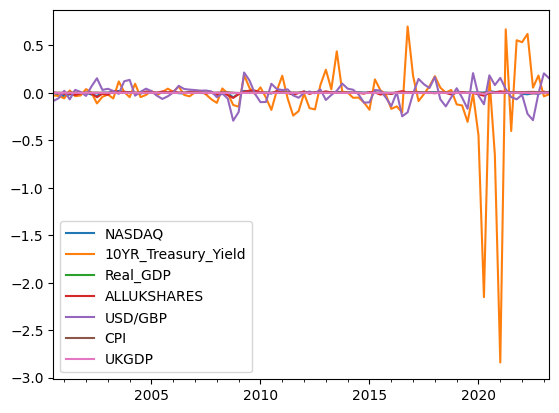

In [117]:
df_stationary.plot()

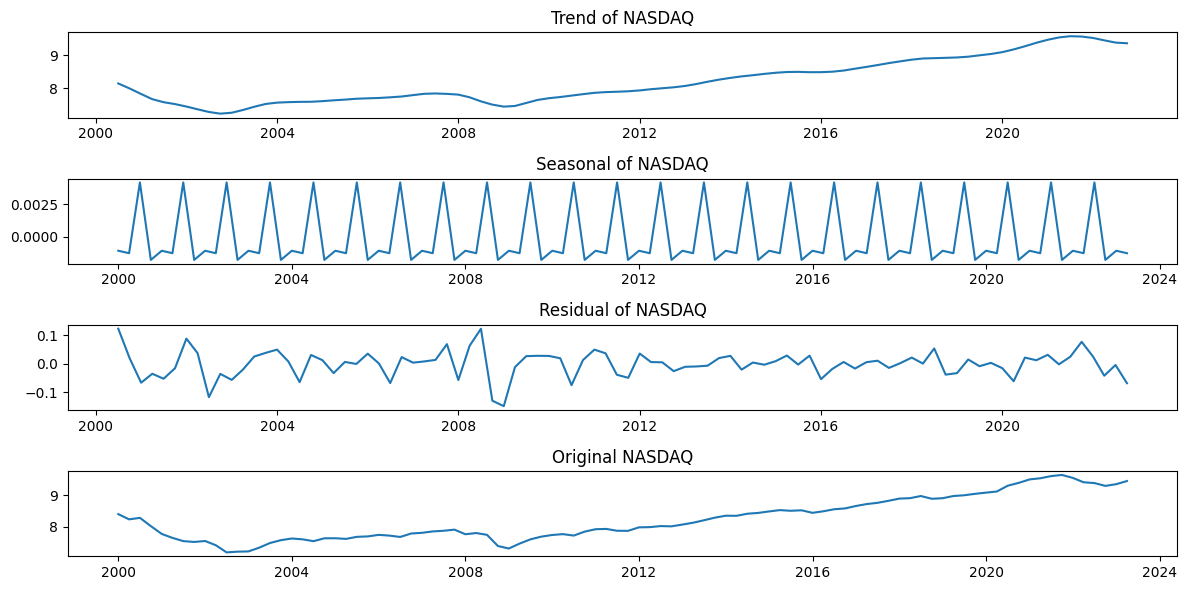

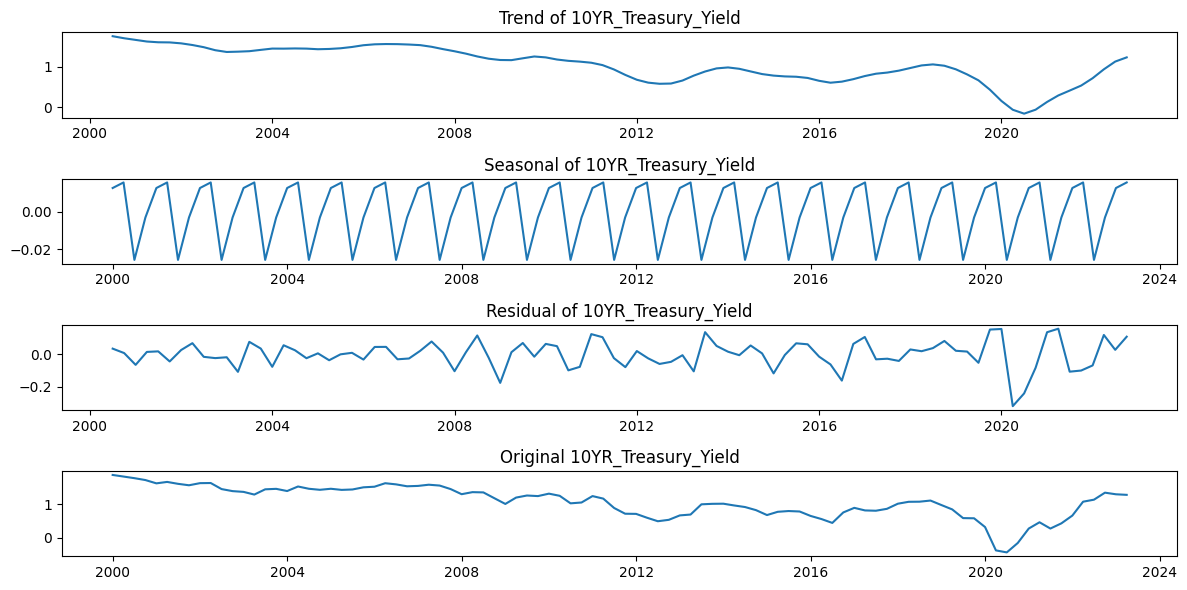

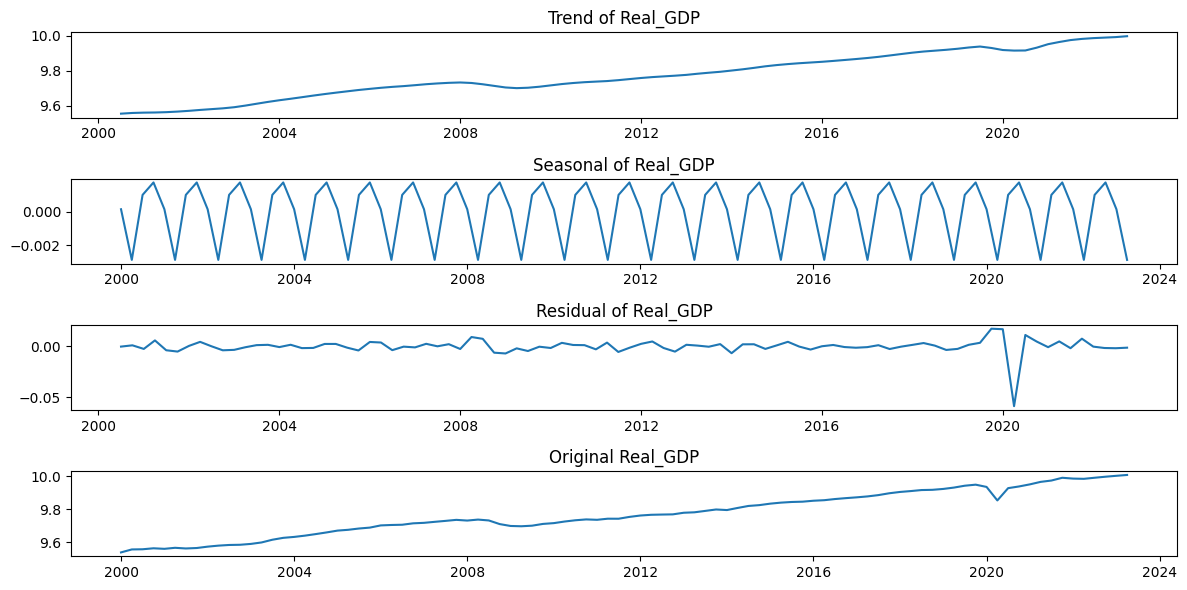

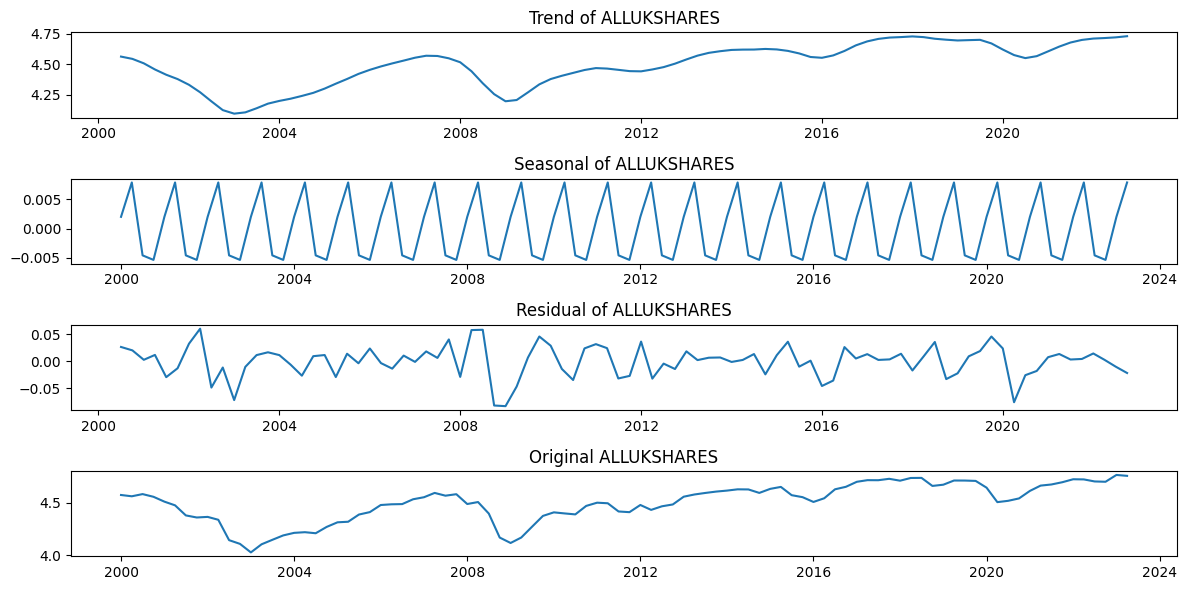

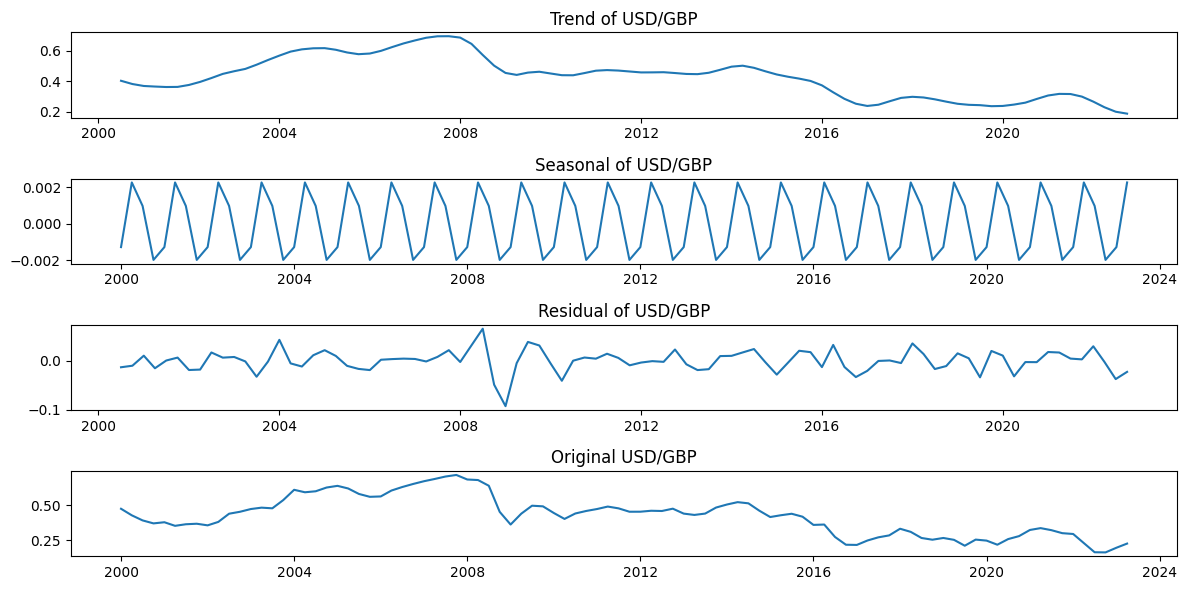

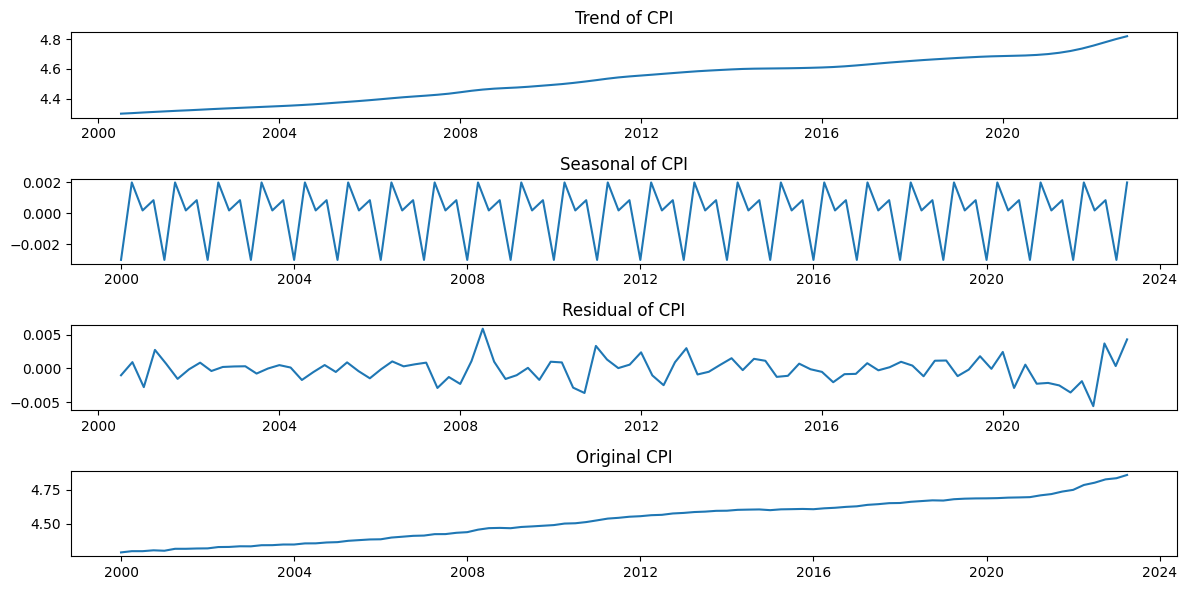

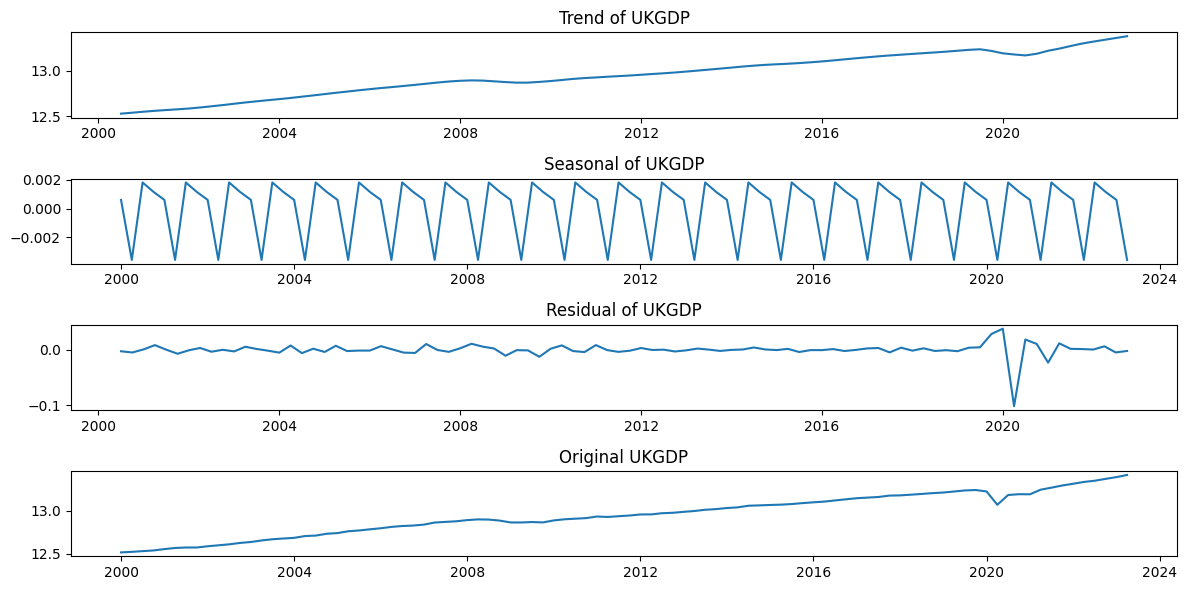

In [118]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_data(data, freq='M'):
    decomposed_data = {}
    dec_trend = pd.DataFrame()

    for column in data.columns:
        # Ensure the data index is a DatetimeIndex
        if not isinstance(data.index, pd.DatetimeIndex):
            raise ValueError("Data index must be a DatetimeIndex.")

        # Drop NA values and set the frequency
        series = data[column]

        # Decompose the time series
        decomposition = sm.tsa.seasonal_decompose(series, model='additive')
        dec_trend[column] = decomposition.trend

        # Store the decomposition components in a dictionary
        decomposed_data[column] = {
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal,
            'residual': decomposition.resid
        }

        # Visualize the decomposed components
        plt.figure(figsize=(12, 6))
        plt.subplot(411)
        plt.plot(decomposed_data[column]['trend'])
        plt.title(f'Trend of {column}')
        plt.subplot(412)
        plt.plot(decomposed_data[column]['seasonal'])
        plt.title(f'Seasonal of {column}')
        plt.subplot(413)
        plt.plot(decomposed_data[column]['residual'])
        plt.title(f'Residual of {column}')
        plt.subplot(414)
        plt.plot(data[column])
        plt.title(f'Original {column}')
        plt.tight_layout()
        plt.show()

    return dec_trend

# Example usage
decomposed_data = decompose_data(df.dropna(), freq='Q')

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


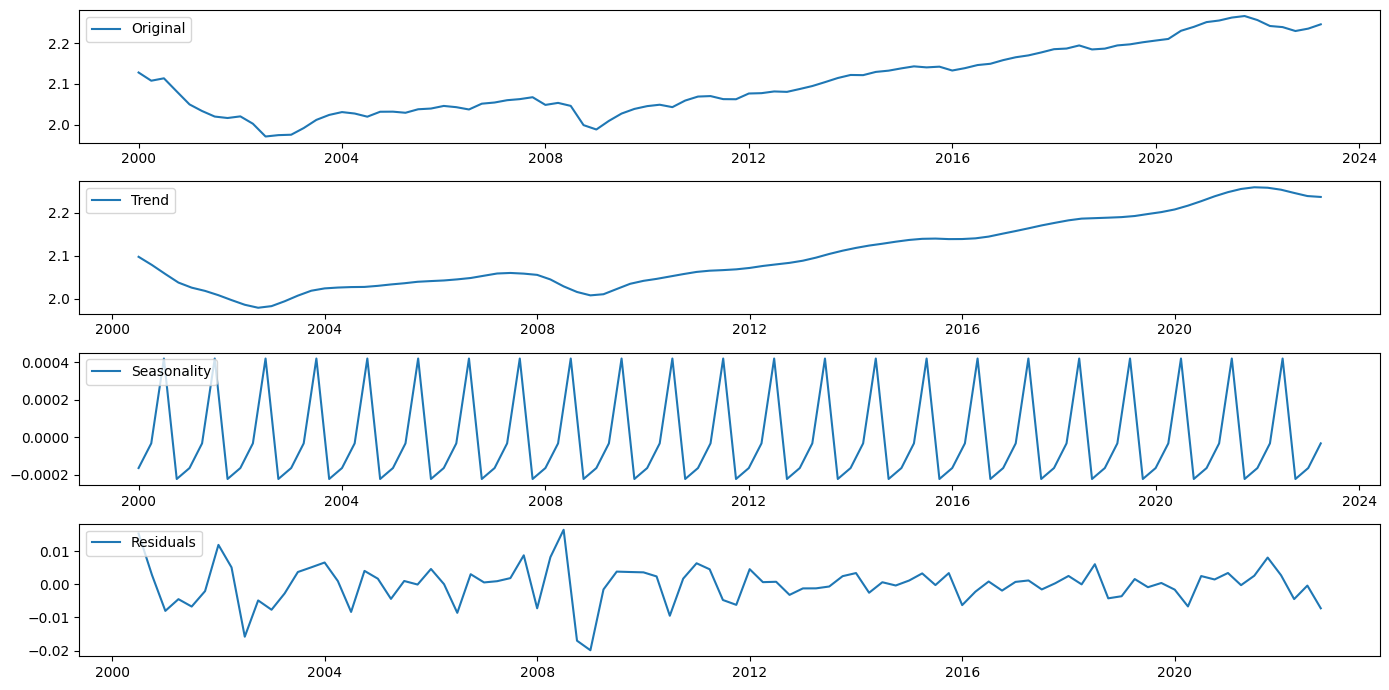

Residual stationarity for NASDAQ: {'ADF Statistic': -5.035131956820684, 'p-value': 0.00017747546789858822, 'critical_values': {'1%': -4.075121979053178, '5%': -3.4661550774027594, '10%': -3.1596113315495042}, 'is_stationary': True}
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   90
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 350.863
Date:                Wed, 15 Nov 2023   AIC                           -689.727
Time:                        22:26:52   BIC                           -674.728
Sample:                    07-01-2000   HQIC                          -683.678
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

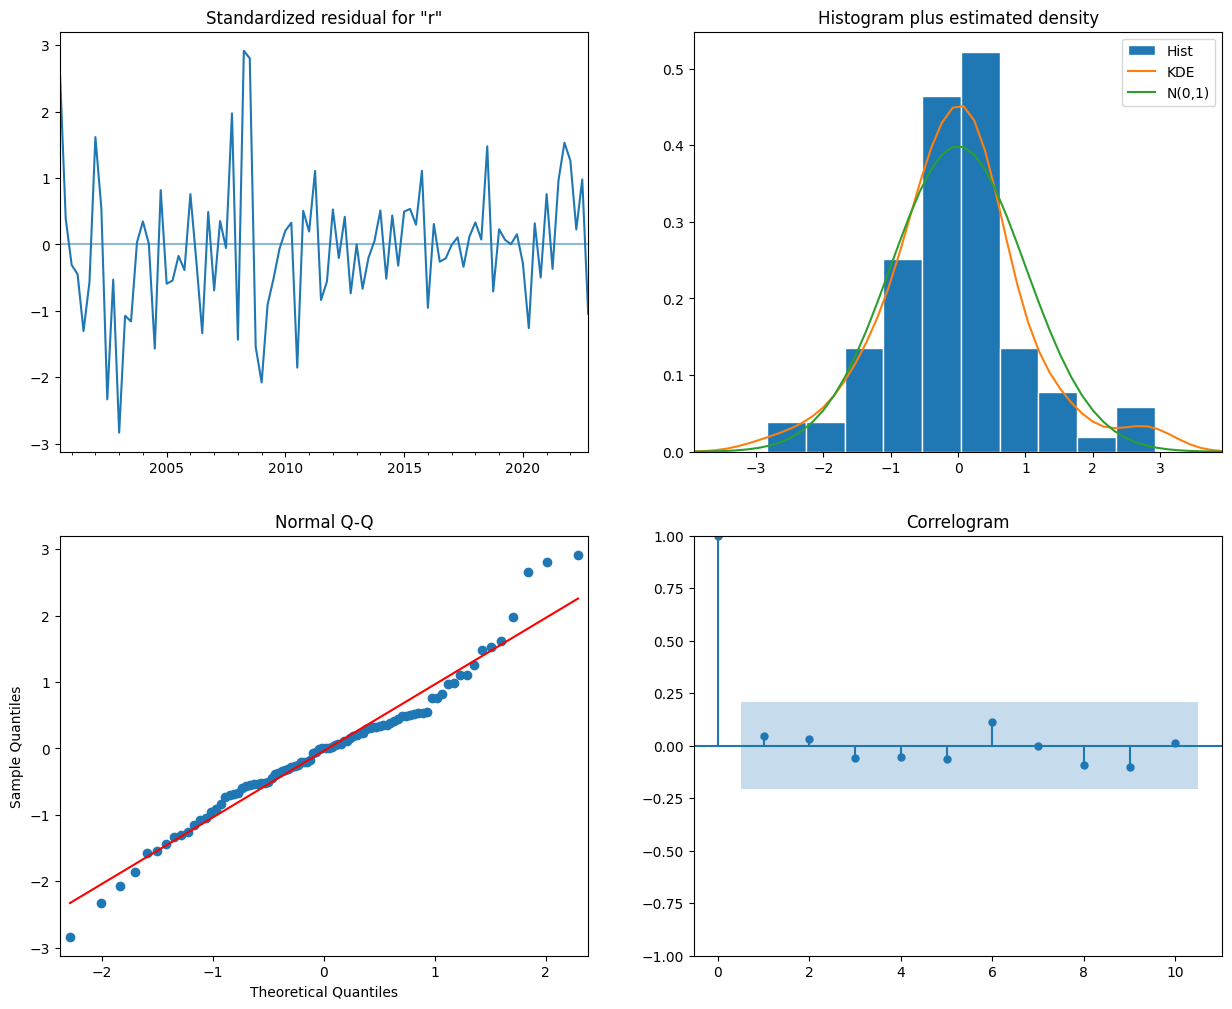

ValueError: ignored

In [120]:
# Assuming previous code for API setup and data retrieval is included

# Justify the choice of series and observation period
# You would include a written justification here, discussing the relevance of the series selected
# and why the observation period and frequency are appropriate for your financial issue of interest.
from statsmodels.tsa.arima.model import ARIMA

# Log Transformation
# Apply log transformation and drop NaN
import numpy as np
# Create a DataFrame from the log-transformed data
df_log = np.log(df)

# Perform unit root test with a trend component
def unit_root_test_with_trend(series):
    # Perform ADF test with a trend component
    adf_test = adfuller(series.dropna(), regression='ct')  # 'ct' includes a trend in ADF regression
    return {
        'ADF Statistic': adf_test[0],
        'p-value': adf_test[1],
        'critical_values': adf_test[4],
        'is_stationary': adf_test[1] < 0.05
    }

# Apply the test for each series and report results
unit_root_results_with_trend = {series: unit_root_test_with_trend(df_log[series]) for series in df_log.columns}

# Decompose each series to analyze different components
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming that 'df_log' is indexed by a DatetimeIndex
for series_name in df_log.columns:
    decomposition = seasonal_decompose(df_log[series_name], model='additive', period=4)  # Quarterly data

    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    residual = decomposition.resid.dropna()

    # Plot the components
    plt.figure(figsize=(14, 7))
    plt.subplot(411)
    plt.plot(df_log[series_name], label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Check if residual is stationary
    residual_stationarity = unit_root_test_with_trend(residual)
    print(f"Residual stationarity for {series_name}: {residual_stationarity}")

# Estimate a stationary ARMA model for the cyclical (residual) component

# Example for one series, repeat for others as needed
    residual_series = decomposition.resid.dropna()  # Use the residual from decomposition
    model_arma = ARIMA(residual_series, order=(2, 0, 2))  # ARIMA(p, d, q) where d=0 for stationary series
    results_arma = model_arma.fit()
    print(results_arma.summary())

# Plot the diagnostics for the ARMA model
    results_arma.plot_diagnostics(figsize=(15, 12))
    plt.show()

# NOTE: The ARIMA order (p, d, q) should be determined based on model selection criteria such as AIC or BIC,
# which may require iterating over different combinations of p and q to find the best model.


Results for column 'NASDAQ' (I(0)):
ADF Statistic: -0.015777168663409138
P-Value: 0.957207713854982
Critical Values:
  1%: -3.503514579651927
  5%: -2.893507960466837
  10%: -2.583823615311909
Series 'NASDAQ' is non-stationary at order I(0) (fail to reject null hypothesis)


Results for column 'NASDAQ' (I(1)):
ADF Statistic: -6.499850730978541
P-Value: 1.1692147712325974e-08
Critical Values:
  1%: -3.503514579651927
  5%: -2.893507960466837
  10%: -2.583823615311909
Series 'NASDAQ' is stationary at order I(1) (reject null hypothesis)
Results for column '10YR_Treasury_Yield' (I(0)):
ADF Statistic: -2.5357197019875266
P-Value: 0.10702342080215116
Critical Values:
  1%: -3.503514579651927
  5%: -2.893507960466837
  10%: -2.583823615311909
Series '10YR_Treasury_Yield' is non-stationary at order I(0) (fail to reject null hypothesis)


Results for column '10YR_Treasury_Yield' (I(1)):
ADF Statistic: -6.751947017560726
P-Value: 2.9358978414047794e-09
Critical Values:
  1%: -3.50434289821397
  

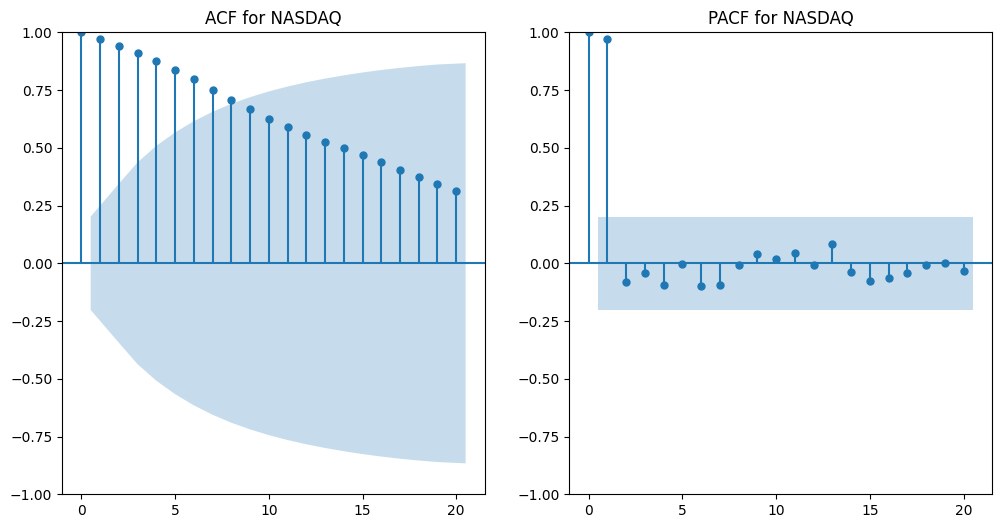

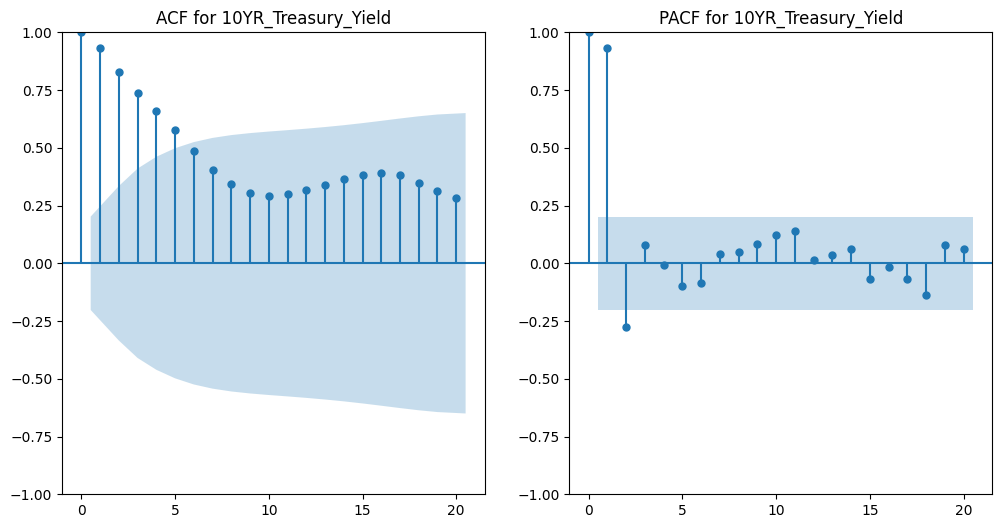

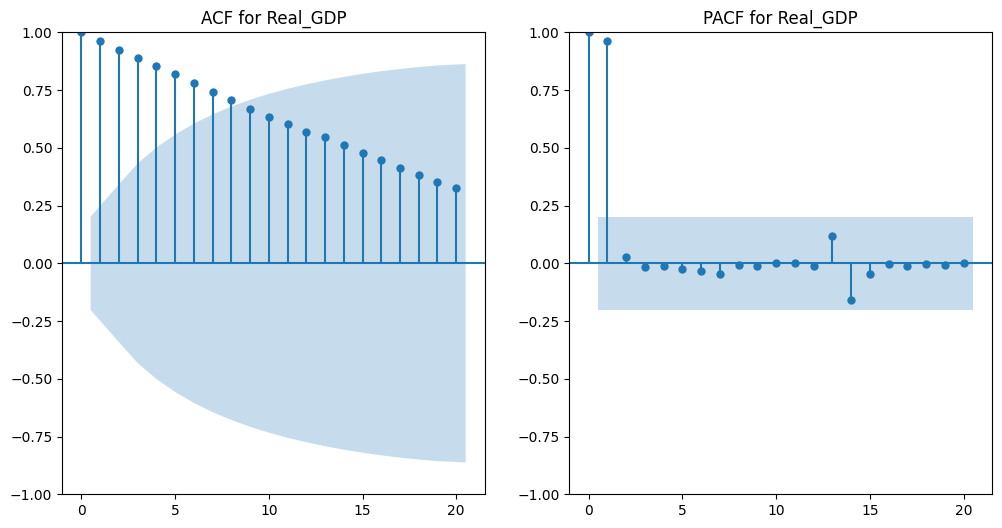

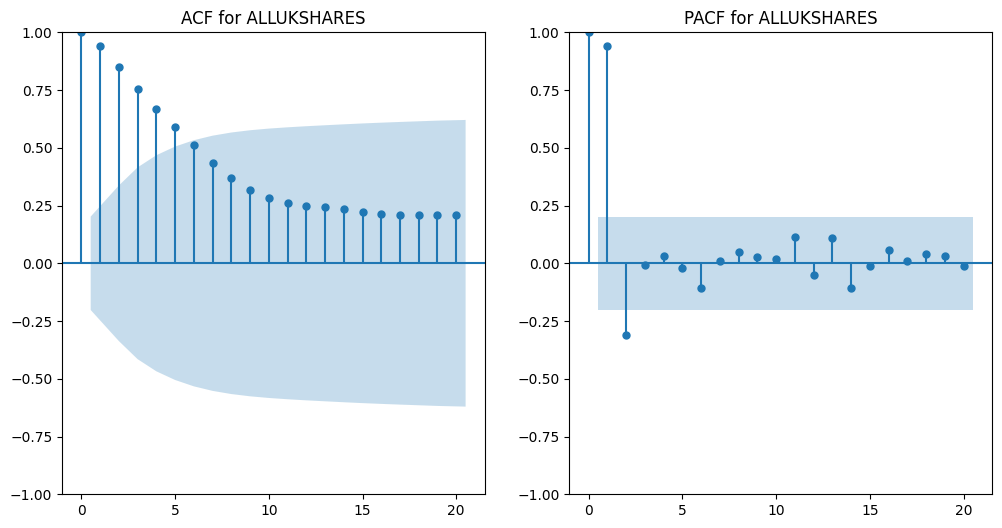

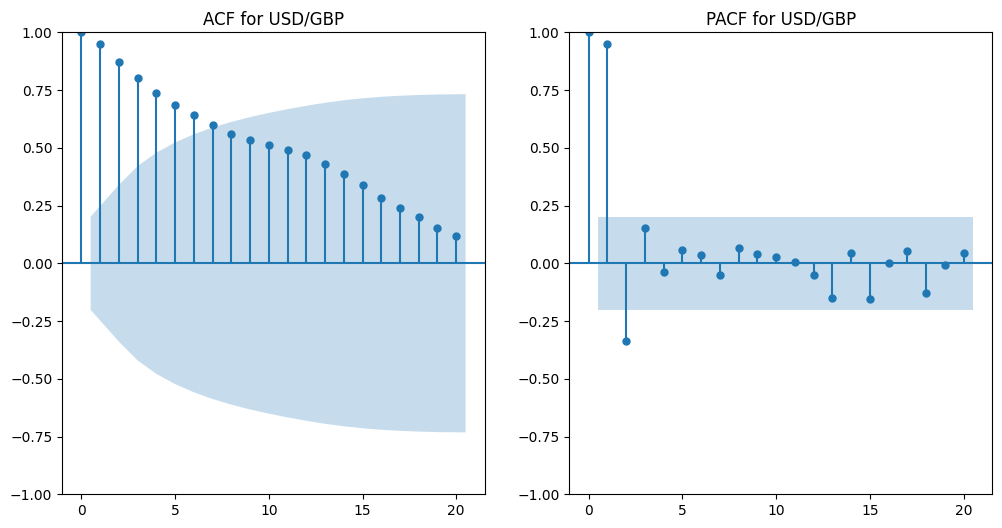

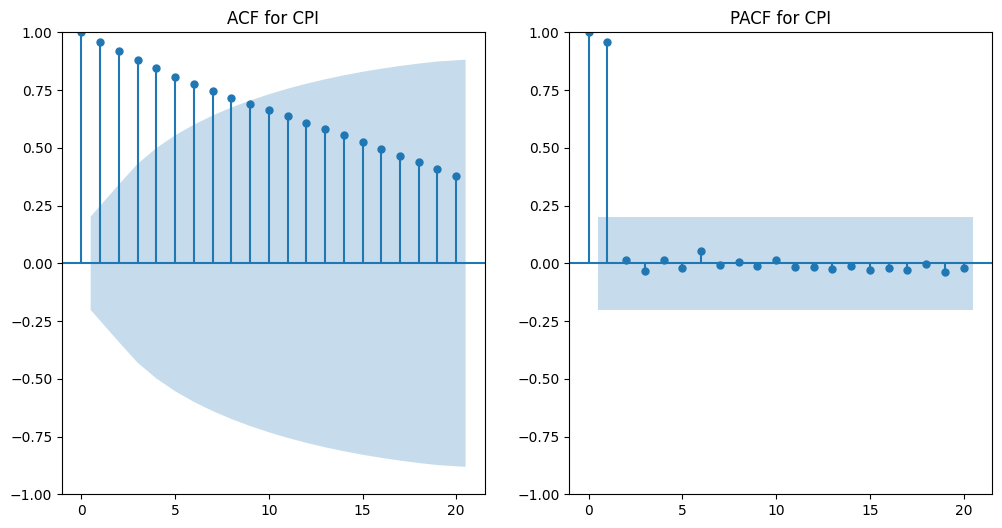

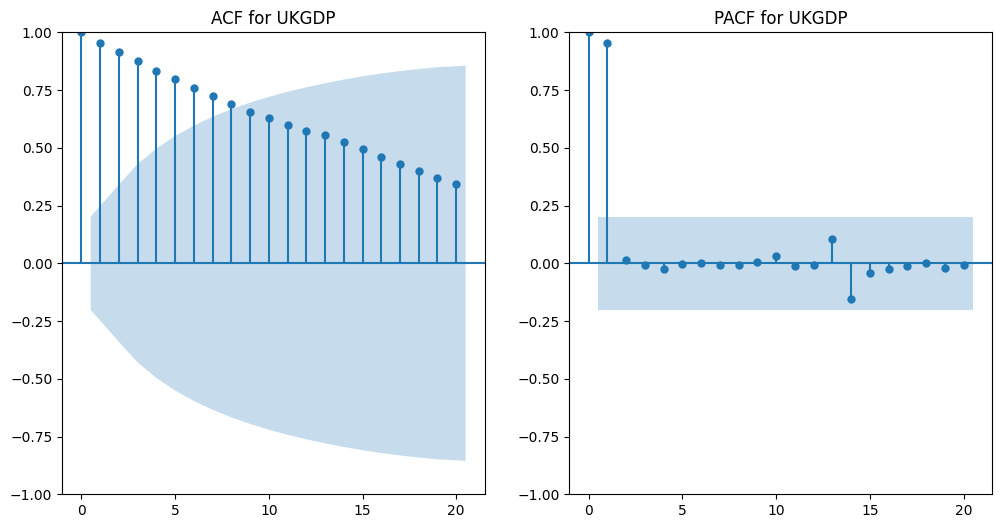

In [121]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
            # Append metrics to DataFrame

def analyze_arima_orders(data, stationnarity_orders,max_lags=20, acf_pacf_lags=20
 ):
    """
    Analyze and find the best ARIMA orders for each column in a DataFrame based on ACF and PACF.

    :param data: A pandas DataFrame with time series data
    :param max_lags: The maximum number of lags to consider for finding the best ARIMA order
    :param acf_pacf_lags: Number of lags to show in ACF and PACF plots
    :return: Dictionary with the best ARIMA orders for each column
    """
    best_orders = {}

    for column in data.columns:
        time_series = data[column]

        # ACF and PACF plots
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        sm.graphics.tsa.plot_acf(time_series, lags=acf_pacf_lags, ax=plt.gca())
        plt.title(f'ACF for {column}')

        plt.subplot(122)
        sm.graphics.tsa.plot_pacf(time_series, lags=acf_pacf_lags, ax=plt.gca())
        plt.title(f'PACF for {column}')
        plt.show()

        # Find the best ARIMA order
        lag_acf = acf(time_series, nlags=max_lags)
        lag_pacf = pacf(time_series, nlags=max_lags, method='ols')

        p = next((x for x, val in enumerate(lag_pacf) if val < abs(0.6)), 0)
        q = next((x for x, val in enumerate(lag_acf) if val < abs(0.6)), 0)

        best_orders[column] = (p, stationnarity_orders.get(column,0), q)  # Assuming d=0 for simplicity

    return best_orders

data_d_orders = determine_differencing_order_for_all(df)
p_q= analyze_arima_orders(df,orders)

In [122]:
p_q

{'NASDAQ': (2, 1, 11),
 '10YR_Treasury_Yield': (2, 1, 5),
 'Real_GDP': (2, 1, 12),
 'ALLUKSHARES': (2, 1, 5),
 'USD/GBP': (2, 1, 7),
 'CPI': (2, 2, 13),
 'UKGDP': (2, 1, 11)}

In [123]:
def fit_and_forecast(df, params):
    forecasts = {}
    test_vs_forecast = {}

    for series_name, (p, d, q) in params.items():
        series = df[series_name].dropna()

        # Splitting the data into train and test sets
        train = series.iloc[:-5]
        test = series.iloc[-5:]

        # Fit AR(1) model
        ar1_model = ARIMA(train, order=(1, d, 0)).fit()
        ar1_forecast = ar1_model.forecast(steps=5)

        # Fit ARIMA model
        arima_model = ARIMA(train, order=(p, d, q)).fit()
        arima_forecast = arima_model.forecast(steps=5)

        # Store forecasts
        forecasts[series_name] = {
            'AR(1) Forecast': ar1_forecast,
            'ARIMA Forecast': arima_forecast,
            'Actual Test Data': test
        }

        # Comparing forecasts with test data
        test_vs_forecast[series_name] = pd.DataFrame({
            'AR(1) Forecast': ar1_forecast,
            'ARIMA Forecast': arima_forecast,
            'Actual Test Data': test
        })

    return forecasts, test_vs_forecast

# Parameters dictionary you provided
arima_params = {
    'NASDAQ': (2, 2, 8),
    '10YR_Treasury_Yield': (2, 1, 7),
    'Real_GDP': (2, 1, 12),
    'ALLUKSHARES': (2, 1, 5),
    'USD/GBP': (2, 1, 7),
    'CPI': (2, 3, 13),
    'UKGDP': (2, 1, 12)
}

# Fit and forecast
forecasts, test_vs_forecast_results = fit_and_forecast(df, arima_params)

# Output the forecast vs actual test data for each series
for series_name, results in test_vs_forecast_results.items():
    print(f"Forecast vs Actual Test Data for {series_name}:")
    print(results)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

Forecast vs Actual Test Data for NASDAQ:
            AR(1) Forecast  ARIMA Forecast  Actual Test Data
2022-04-01        9.492169        9.536536          9.408801
2022-07-01        9.425290        9.531238          9.383543
2022-10-01        9.362128        9.557564          9.293889
2023-01-01        9.297833        9.609294          9.348487
2023-04-01        9.233883        9.623591          9.447525
Forecast vs Actual Test Data for 10YR_Treasury_Yield:
            AR(1) Forecast  ARIMA Forecast  Actual Test Data
2022-04-01        0.732301        0.681950          1.075002
2022-07-01        0.753288        0.515759          1.134623
2022-10-01        0.759615        0.317860          1.342865
2023-01-01        0.761522        0.293794          1.294727
2023-04-01        0.762097        0.391440          1.278152
Forecast vs Actual Test Data for Real_GDP:
            AR(1) Forecast  ARIMA Forecast  Actual Test Data
2022-04-01        9.987103        9.957678          9.985444
2022-07-

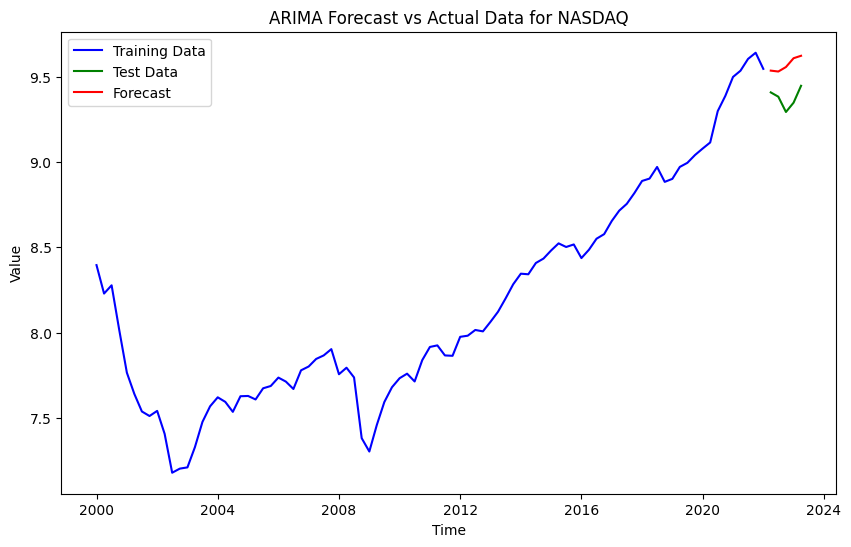

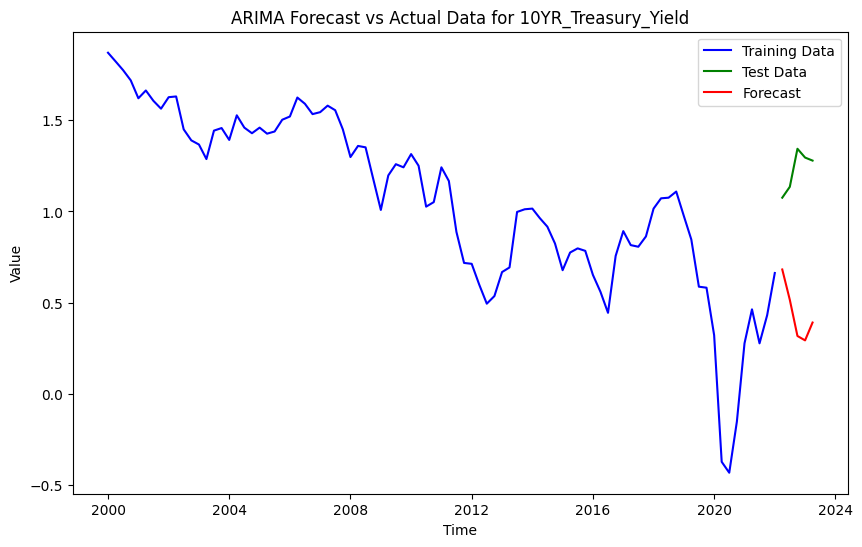

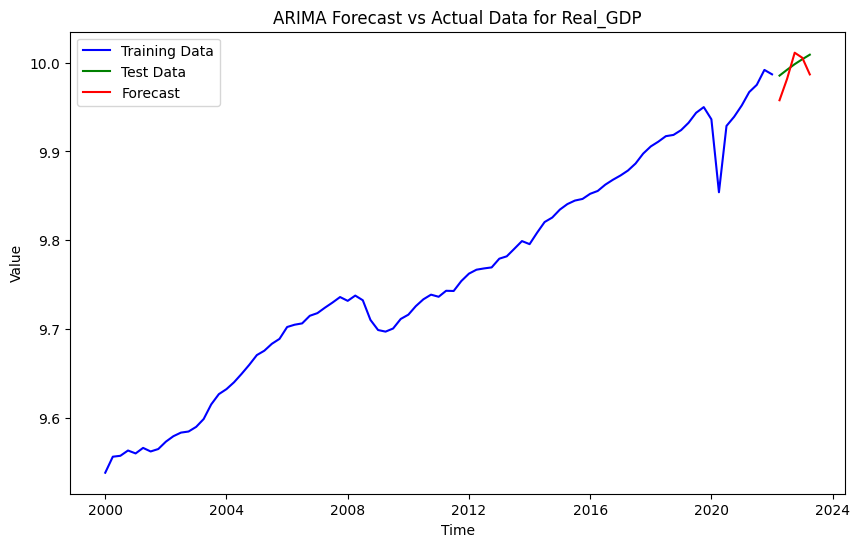

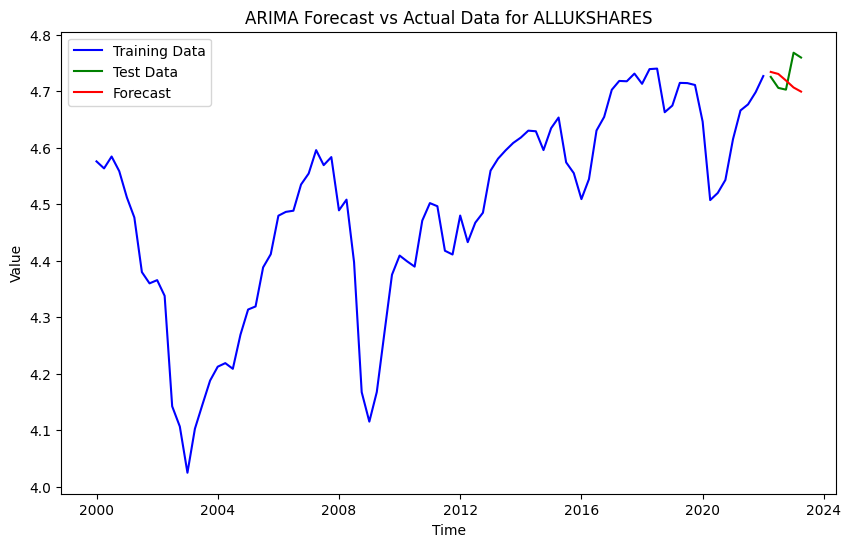

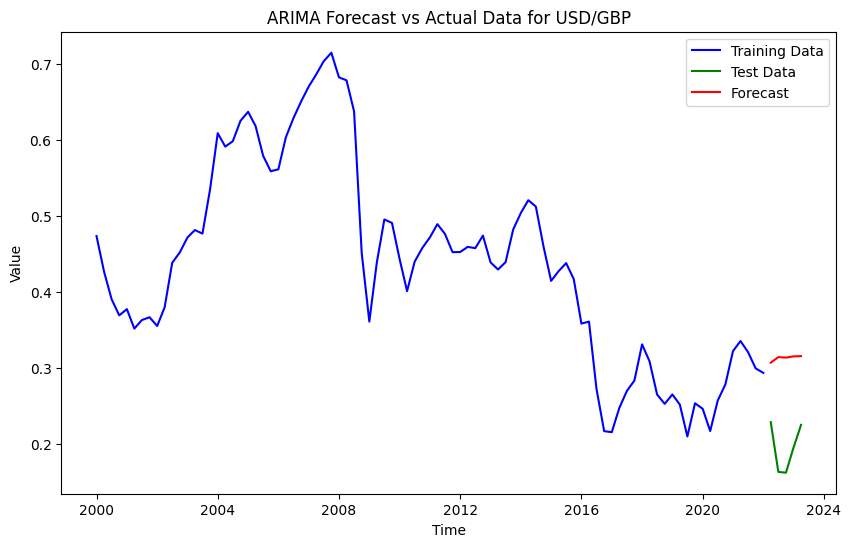

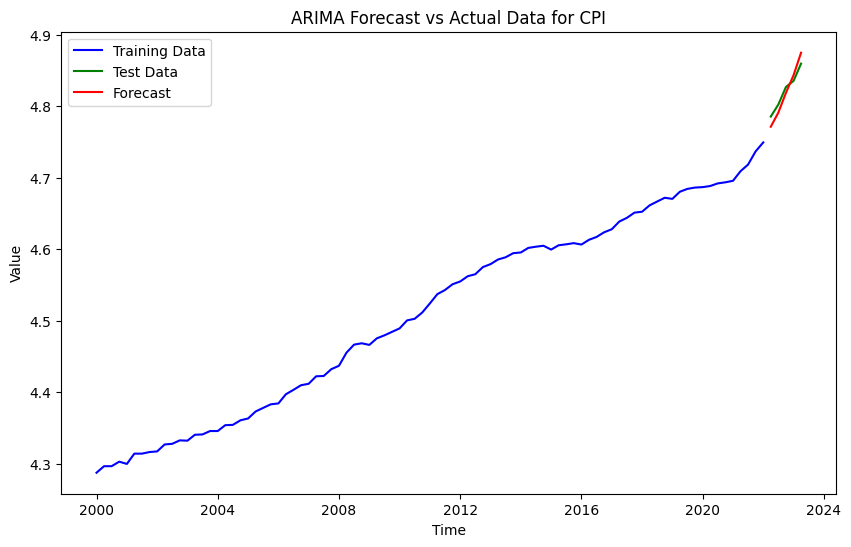

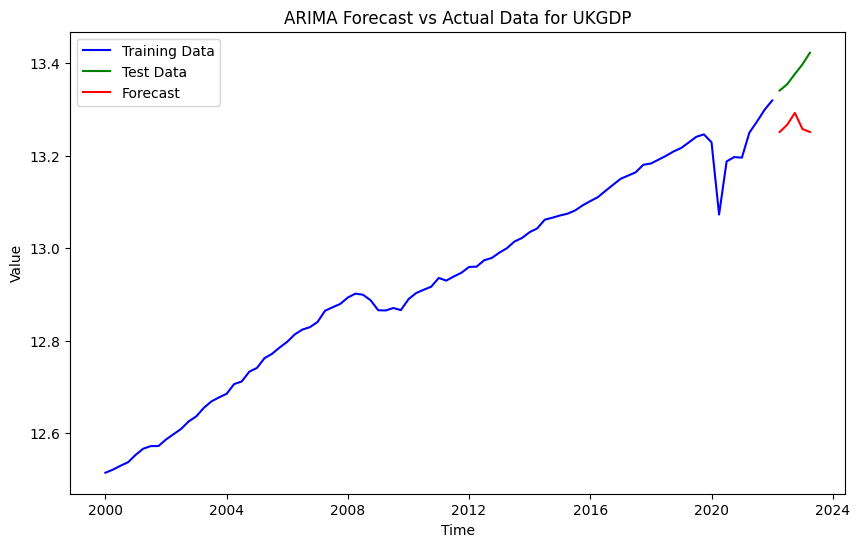

In [129]:
import matplotlib.pyplot as plt

def plot_forecasts(train, test, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train, color='blue', label='Training Data')
    plt.plot(test, color='green', label='Test Data')

    plt.plot(test.index, forecast, color='red', label='Forecast')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Using the results from the fit_and_forecast function
for series_name, results in test_vs_forecast_results.items():
    train = df[series_name].iloc[:-5].dropna()  # Training data
    test = results['Actual Test Data']          # Test data
    forecast = results['ARIMA Forecast']        # Forecast data

    plot_forecasts(train, test, forecast, f"ARIMA Forecast vs Actual Data for {series_name}")


In [71]:

# VAR Model without differencing
model = VAR(df)
results = model.fit(maxlags=5, ic='aic')
print(results.summary())

# VAR Model with stationnary data
model_diff = VAR(df_stationary)
results_diff = model_diff.fit(maxlags=5, ic='aic')
print(results_diff.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Nov, 2023
Time:                     20:37:31
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    38.8661
Nobs:                     87.0000    HQIC:                   34.5996
Log likelihood:          -1992.10    FPE:                8.66468e+13
AIC:                      31.7235    Det(Omega_mle):     7.67453e+12
--------------------------------------------------------------------
Results for equation NASDAQ
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                      -8559.924457      7326.406809           -1.168           0.243
L1.NASDAQ                      1.250098         0.170269            7.342           0.000
L1.10YR_Treasury_Yield 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


#VAR Model with Original Series
##Model Statistics:

The AIC, BIC, and HQIC values are relatively high, suggesting a certain level of model complexity.
A notable number of lags (5) were included, indicating potential complexity in the interrelations among series.
Coefficients:

For the NASDAQ equation, coefficients like L1.NASDAQ (lag 1 of NASDAQ) are significant (p < 0.05), implying a strong autocorrelation.
The coefficients of other variables in the NASDAQ equation (like L1.10YR_Treasury_Yield, L1.Real_GDP) are mostly not significant, suggesting less direct influence from these series on NASDAQ movements.
In the 10YR_Treasury_Yield equation, L1.10YR_Treasury_Yield and L1.ALLUKSHARES are significant, suggesting past values of these series and stock indices (like ALLUKSHARES) influence current Treasury yields.
Interdependencies:

The relationships between different financial series seem complex, as indicated by the significance of lagged values of different series in each equation.
For example, the NASDAQ is influenced by its own past values and slightly by UK GDP (L3.UKGDP), hinting at international economic interdependencies.
#VAR Model with Stationary Data
##Model Statistics:

Lower AIC, BIC, and HQIC values compared to the non-stationary model suggest a better fit.
This indicates that making the data stationary helps in capturing the underlying dynamics more effectively.
##Coefficients:

The coefficients' significance patterns change here. For example, in the NASDAQ equation, the L1.NASDAQ is still significant, but others like L1.10YR_Treasury_Yield are not.
In the 10YR_Treasury_Yield equation, L1.ALLUKSHARES becomes more influential, which could mean stock market indices impact treasury yields more directly in the differenced model.
##Interdependencies:

The relationships between series are clearer in the stationary model. For example, CPI seems to be influenced by its own past values and by Real_GDP, suggesting macroeconomic factors play a role in inflation dynamics.
##Overall Interpretation and Recommendations
The stationary model appears to provide a clearer and potentially more accurate representation of the dynamics between the series.
The original series model indicates that variables like NASDAQ and 10YR_Treasury_Yield are influenced significantly by their own past values, indicating potential autocorrelation issues.
For both models, the significance of cross-lagged terms (like stock indices impacting Treasury yields or vice versa) highlights the interconnected nature of financial markets.
For future analysis, you may consider exploring other modeling techniques that can handle non-stationarity more effectively, such as Vector Error Correction Models (VECM) if cointegration is detected, or possibly other non-linear models.
Ensure to check for residual diagnostics to confirm model adequacy, including tests for autocorrelation, heteroscedasticity, and normality of residuals.

In [73]:
from itertools import combinations
from statsmodels.tsa.stattools import coint

co_integrated_series = []
for col1, col2 in combinations(df.columns, 2):
    coint_test = coint(df[col1].dropna(), df[col2].dropna())
    p_value = coint_test[1]
    #print(f'Cointegration test p-value between {col1} and {col2}: {p_value}')
    if p_value < 0.05:
      co_integrated_series.append((col1,col2))


print(co_integrated_series)
#[('Real_GDP', 'UKGDP'), ('ALLUKSHARES', 'CPI'), ('ALLUKSHARES', 'UKGDP'), ('CPI', 'UKGDP')]


[('Real_GDP', 'UKGDP'), ('ALLUKSHARES', 'CPI'), ('ALLUKSHARES', 'UKGDP'), ('CPI', 'UKGDP')]


In [130]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def perform_johansen_test(data, det_order=-1, k_ar_diff=1):
    """
    Perform the Johansen cointegration test on a given dataset.

    :param data: A pandas DataFrame with time series data.
    :param det_order: The order of deterministic terms to include (-1, 0, 1).
    :param k_ar_diff: The number of lags to be used.
    :return: Johansen test result object.
    """
    johansen_test = coint_johansen(data, det_order, k_ar_diff)
    return johansen_test

# Example usage
johansen_results = perform_johansen_test(df)
print(johansen_results.lr1)  # Eigenvalues
print(johansen_results.cvt)  # Critical values
#[150.05866284  75.76419175  39.96126918  23.92935328  11.33556313
   4.54840719   0.71035539]
[[106.7351 111.7797 121.7375]
 [ 79.5329  83.9383  92.7136]
 [ 56.2839  60.0627  67.6367]
 [ 37.0339  40.1749  46.5716]
 [ 21.7781  24.2761  29.5147]
 [ 10.4741  12.3212  16.364 ]
 [  2.9762   4.1296   6.9406]]

[150.05866284  75.76419175  39.96126918  23.92935328  11.33556313
   4.54840719   0.71035539]
[[106.7351 111.7797 121.7375]
 [ 79.5329  83.9383  92.7136]
 [ 56.2839  60.0627  67.6367]
 [ 37.0339  40.1749  46.5716]
 [ 21.7781  24.2761  29.5147]
 [ 10.4741  12.3212  16.364 ]
 [  2.9762   4.1296   6.9406]]


##VECM


In [78]:
from statsmodels.tsa.vector_ar.vecm import VECM

def apply_vecm_to_pairs(data, pairs, k_ar_diff=5, coint_rank=1):
    results = {}
    for pair in pairs:
        model = VECM(data[list(pair)], k_ar_diff=k_ar_diff, coint_rank=coint_rank)
        result = model.fit()
        results[pair] = result
    return results

# Example usage
vecm_results = apply_vecm_to_pairs(df, co_integrated_series)

for pair, result in vecm_results.items():
    print(f"Results for VECM Model - Pair: {pair}")
    print(result.summary())
    print("\n" + "-"*50 + "\n")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Results for VECM Model - Pair: ('Real_GDP', 'UKGDP')
Det. terms outside the coint. relation & lagged endog. parameters for equation Real_GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Real_GDP     0.1187      0.297      0.399      0.690      -0.464       0.701
L1.UKGDP       -0.0095      0.007     -1.454      0.146      -0.022       0.003
L2.Real_GDP    -0.1839      0.293     -0.629      0.530      -0.757       0.390
L2.UKGDP        0.0003      0.006      0.046      0.964      -0.012       0.013
L3.Real_GDP     0.1712      0.255      0.671      0.502      -0.329       0.671
L3.UKGDP       -0.0069      0.006     -1.165      0.244      -0.018       0.005
L4.Real_GDP     0.1864      0.280      0.666      0.506      -0.362       0.735
L4.UKGDP       -0.0048      0.007     -0.693      0.489      -0.018       0.009
L5.Real_GDP     0.0946      0.270      0.350      0.726    

Here's a brief overview of the key elements from your results:

#VECM Model - Pair: ('Real_GDP', 'UKGDP'):

##Lagged Endogenous Parameters for 'Real_GDP' and 'UKGDP' Equations:
These coefficients represent the short-term dynamics of the system. The values show how past values of 'Real_GDP' and 'UKGDP' influence their current values.

##Loading Coefficients (alpha):
 These coefficients measure the speed at which the variables adjust to restore the equilibrium in case of any short-term deviations. For 'Real_GDP', the coefficient is 0.0139, and for 'UKGDP', it is 0.5213, suggesting that 'UKGDP' adjusts at a faster rate compared to 'Real_GDP'.

##Cointegration Relations (beta):
 This shows the long-term equilibrium relationship between 'Real_GDP' and 'UKGDP'. The coefficients indicate that for every unit change in 'Real_GDP', 'UKGDP' changes by -0.0166.

#VECM Model - Pair: ('ALLUKSHARES', 'CPI')
##Lagged Endogenous Parameters for 'ALLUKSHARES' and 'CPI' Equations:
 These coefficients are similar to the previous pair, showing the short-term dynamics between 'ALLUKSHARES' and 'CPI'.

##Loading Coefficients:
The coefficients for 'ALLUKSHARES' (-0.2487) and 'CPI' (-0.0055) show the rate of adjustment to the long-term equilibrium.

#Cointegration Relations:
 The long-term relationship suggests that 'ALLUKSHARES' and 'CPI' are negatively related, as indicated by the coefficient of -1.0256 for 'CPI'.

#VECM Model - Pair: ('ALLUKSHARES', 'UKGDP')
##Lagged Endogenous Parameters:
 These coefficients show the short-term interdependencies between 'ALLUKSHARES' and 'UKGDP'.

##Loading Coefficients:
 The coefficients -0.0772 for 'ALLUKSHARES' and -199.7150 for 'UKGDP' indicate the speed of adjustment towards the long-term equilibrium.

##Cointegration Relations:
 The long-term equilibrium relationship is indicated by the beta coefficients, with a very small negative coefficient for 'UKGDP'.

#VECM Model - Pair: ('CPI', 'UKGDP')
##Lagged Endogenous Parameters:
 This part of the result shows the short-term interaction between 'CPI' and 'UKGDP'.

##Loading Coefficients:
The coefficients for 'CPI' (0.0003) and 'UKGDP' (268.5921) show how quickly these variables adjust to the long-term equilibrium.

##Cointegration Relations:
The relationship indicates a small negative coefficient for 'UKGDP' in the long-term equilibrium.

#General Observations
Cointegration and Error Correction: The presence of cointegration indicates a long-term equilibrium relationship between the pairs of variables. The error correction terms (alpha coefficients) represent how quickly deviations from this long-term equilibrium are corrected.

Short-Term Dynamics: The coefficients of lagged endogenous variables capture the short-term dynamics and show how previous periods' values affect the current period.

Statistical Significance: It's crucial to consider the statistical significance of these coefficients (indicated by P>|z| values). Coefficients with high P-values might not be statistically significant.

In summary, these results provide insight into both the short-term dynamics and long-term relationships between pairs of financial series, helping in understanding how these variables interact over time.

Results for VECM Model - Pair: ('Real_GDP', 'UKGDP')


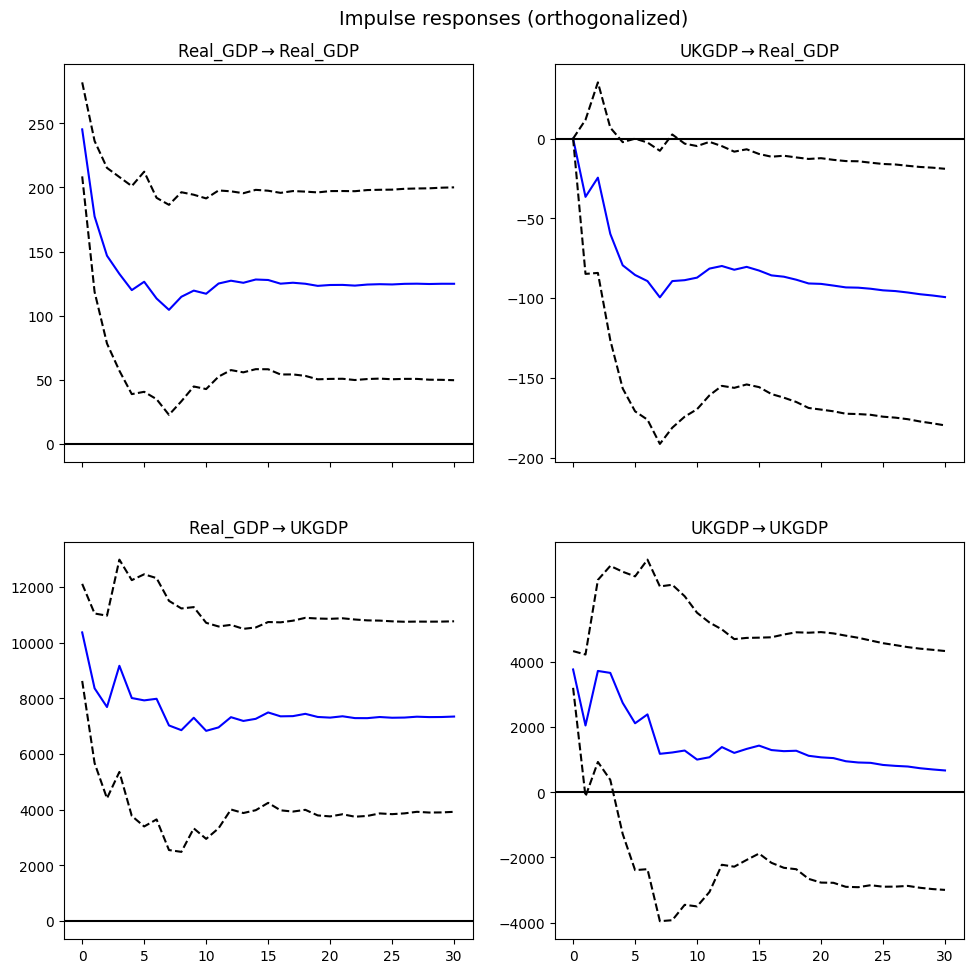


--------------------------------------------------

Results for VECM Model - Pair: ('ALLUKSHARES', 'CPI')


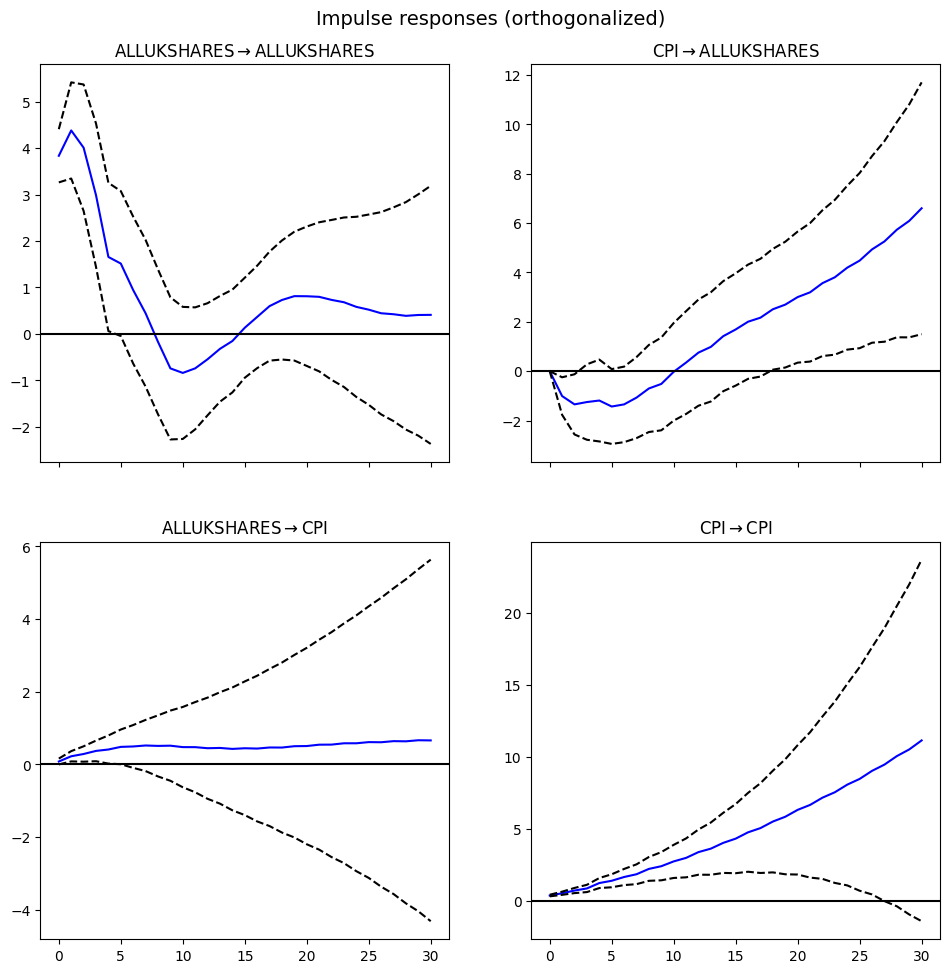


--------------------------------------------------

Results for VECM Model - Pair: ('ALLUKSHARES', 'UKGDP')


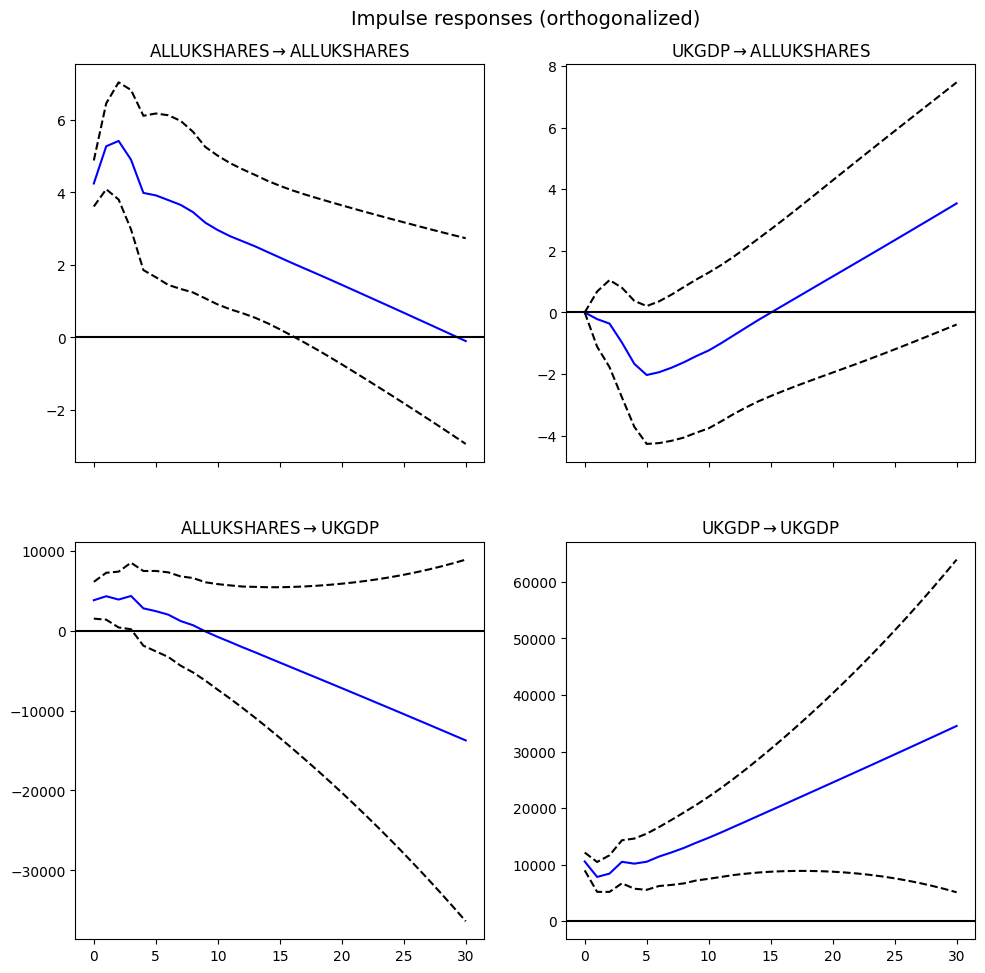


--------------------------------------------------

Results for VECM Model - Pair: ('CPI', 'UKGDP')


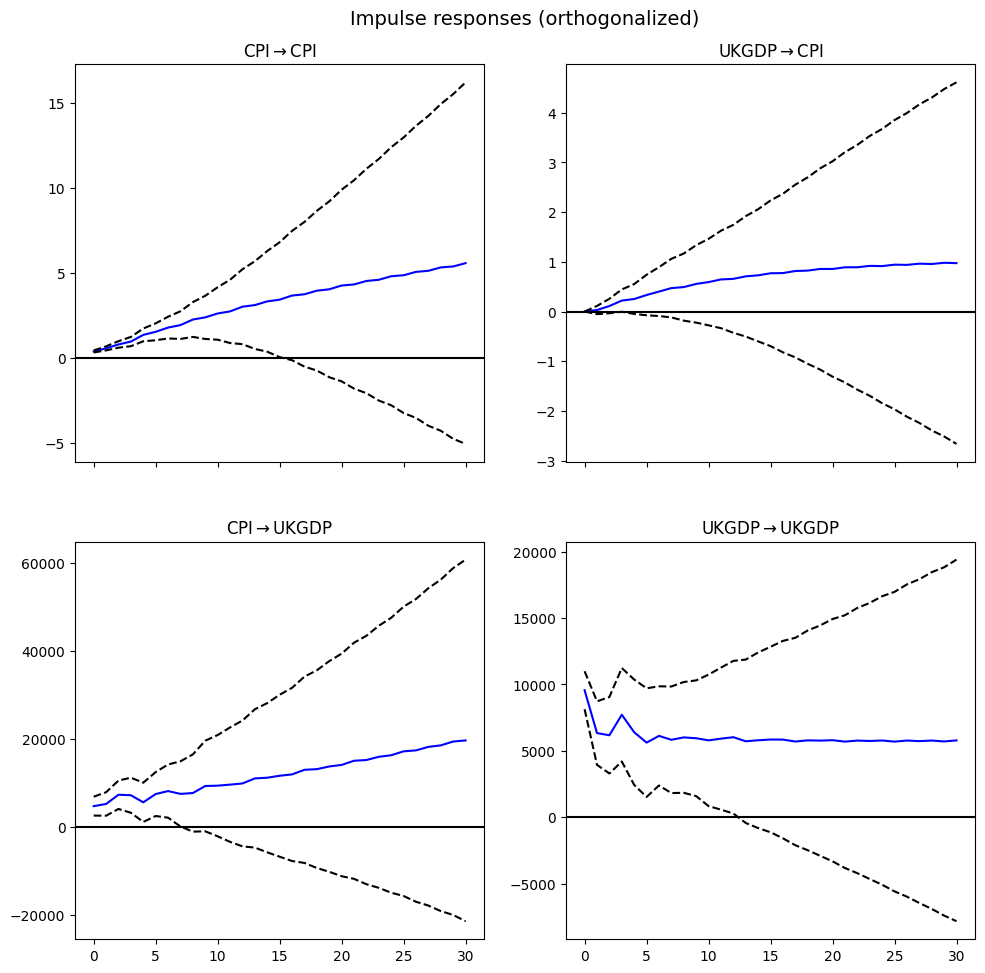


--------------------------------------------------



In [80]:
import matplotlib.pyplot as plt

# Assuming 'vecm_results' is the result of your VECM models
for pair, result in vecm_results.items():
    print(f"Results for VECM Model - Pair: {pair}")


    # Generating impulse response functions
    irf = result.irf(periods=30) # You can change the number of periods as needed

    # Plotting the impulse response functions
    irf_fig = irf.plot(orth=True) # orth=True for orthogonalized IRFs
    plt.show()

    print("\n" + "-"*50 + "\n")


#CPI Response to Shocks:

##CPI → CPI:
 The Consumer Price Index (CPI) responds positively to its own shock, suggesting a persistent inflationary impact.
UKGDP → CPI: A shock to UK GDP has an initial negative impact on CPI but then leads to a gradual increase, indicating a delayed inflationary effect from GDP growth.
UKGDP Response to Shocks:

##CPI → UKGDP:
Shocks in CPI appear to have a large and positive impact on UKGDP after an initial period of adjustment.
UKGDP → UKGDP: The UK GDP responds negatively to its own shock initially but then stabilizes, which could reflect an overreaction and subsequent correction in the economy.
ALLUKSHARES Response to Shocks:

##ALLUKSHARES → ALLUKSHARES:
 The stock index (ALLUKSHARES) has a diminishing positive response to its own shock, suggesting a short-term positive impact on stock prices that fades over time.
UKGDP → ALLUKSHARES: A shock to UKGDP has a volatile response in the stock index, initially negative, then positive, and eventually stabilizing. This could reflect uncertainty and adjustments in the market following economic growth or contraction.

#Interactions between ALLUKSHARES, CPI, and UKGDP:

The responses between ALLUKSHARES, CPI, and UKGDP show a mix of positive and negative impacts, with some indicators suggesting that shocks in stock prices have a relatively persistent negative effect on GDP and a variable effect on inflation.
Conversely, shocks to GDP and CPI can have both immediate and delayed impacts on stock prices, indicating the complex interplay between these economic indicators.

In all cases, the confidence intervals widen as the time horizon extends, reflecting increased uncertainty about the impact of shocks over longer periods. It's also noteworthy that the responses do not always return to zero, suggesting that some shocks may have a permanent effect on the level of the variables.